In [17]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

data_dir = Path("../data")
plot_dir = Path("plots")

transactions = pl.scan_parquet(data_dir / "transactions_train_3.parquet").filter(pl.col("label") != "UNKNOWN")

In [18]:
df = (
    transactions
    .with_columns([
        pl.col("transaction_start").dt.hour().alias("hour"),
    ])
    .group_by("hour")
    .agg([
        pl.len().alias("total"),
        pl.col("label").filter(pl.col("label") == "FRAUD").count().alias("fraud_count")
    ])
    .with_columns(
        (pl.col("fraud_count") / pl.col("total")).alias("fraud_rate")
    )
    .select(["hour", "fraud_rate"])
).collect().to_pandas()

In [34]:
label_counts = (
 transactions.group_by("label")
        .agg(pl.len().alias("count"))
        .with_columns((pl.col("count") / pl.col("count").sum()).alias("proportion"))
        .sort("count", descending=True)
)
label_counts.collect()

label,count,proportion
str,u32,f64
"""NORMAL""",143369,0.968546
"""FRAUD""",4656,0.031454


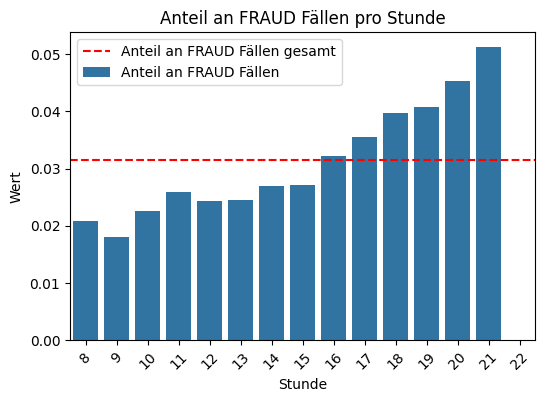

In [41]:
fraud_rate_total = label_counts.filter(pl.col("label") == "FRAUD").select("proportion").collect().to_numpy()[0][0]

plt.figure(figsize=(6, 4))
sns.barplot(data=df, x='hour', y='fraud_rate', label='Anteil an FRAUD Fällen')

plt.axhline(fraud_rate_total, color='red', linestyle='--', label='Anteil an FRAUD Fällen gesamt')

plt.title('Anteil an FRAUD Fällen pro Stunde')
plt.xlabel('Stunde')
plt.ylabel('Wert')
plt.xticks(rotation=45)
plt.legend()

plt.savefig(plot_dir / "anteil_fraud_nach_stunde.png", dpi=300, bbox_inches='tight')
plt.show()